In [1]:
%matplotlib inline

# Common imports

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
results_dir = '../Results/{}_{:02}'.format(year, month)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Parameters to make prettier plots

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

# Reading in the data from sleuth

In [4]:
df = pd.read_csv('../Data/Kallisto_output/sleuth_rna_lrt.tsv', sep='\t')
df.set_index('target_id', inplace=True)
df.head()

,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
target_id,,,,,,,,,,,
b0150_fhuA,2.081298e-07,0.000383,26.956095,2.675645,1,7.609299,0.891882,0.000675,0.891206,0.012725,0.891206
b1452_yncE,6.504661e-07,0.000383,24.756573,2.849337,1,6.694600,0.949779,0.001476,0.948303,0.012933,0.948303
b3162_deaD,6.086554e-07,0.000383,24.884637,1.713631,1,9.635700,0.571210,0.000064,0.571147,0.010277,0.571147
b3417_malP,4.976469e-07,0.000383,25.272919,4.761662,1,6.130382,1.587221,0.003463,1.583757,0.014127,1.583757
b3418_malT,5.854542e-07,0.000383,24.959563,1.920871,1,7.615709,0.640290,0.000617,0.639674,0.012721,0.639674


# And from kallisto

In [5]:
df_exp = pd.read_csv('../Data/Kallisto_output/kallisto_rna.tsv', sep='\t')
df_exp.head()

,target_id,sample,est_counts,tpm,eff_len,len,condition
1,b0001_thrL,RIBOTrep1,516.371434,5311.636414,8.781648,66,RiboT
2,b0001_thrL,RIBOTrep2,471.480351,4856.056700,8.781648,66,RiboT
3,b0001_thrL,WTrep1,453.127495,4657.632225,8.781648,66,WT
4,b0001_thrL,WTrep2,462.790030,4754.580149,8.781648,66,WT
5,b0002_thrA,RIBOTrep1,2366.930085,90.975709,2350.185433,2463,RiboT


# Combining these results into a single master table

In [6]:
df_exp_pivot = df_exp.pivot_table(values=['tpm', 'est_counts'], index='target_id', columns=['sample'])
temp_df_exp_pivot = df_exp.pivot_table(values=['len'], index='target_id', columns=['sample'])
assert list(df_exp_pivot.index) == list(temp_df_exp_pivot.index)
df_exp_pivot['length'] = temp_df_exp_pivot['len']['WTrep1']
df_exp_pivot.columns = ['_'.join(col).strip().strip('_') for col in df_exp_pivot.columns.values]
df_master = pd.concat([df_exp_pivot, df], axis=1)
df_master.head()

,est_counts_RIBOTrep1,est_counts_RIBOTrep2,est_counts_WTrep1,est_counts_WTrep2,tpm_RIBOTrep1,tpm_RIBOTrep2,tpm_WTrep1,tpm_WTrep2,length,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
b0001_thrL,516.371434,471.480351,453.127495,462.790030,5311.636414,4856.056700,4657.632225,4754.580149,66,0.030031,0.074295,4.707506,0.009907,1.0,6.165090,0.003302,0.002039,0.001263,0.013995,0.013995
b0002_thrA,2366.930085,1980.217476,5821.600428,5964.422549,90.975709,76.128766,224.050831,229.210160,2463,0.000065,0.002262,15.943075,1.018492,1.0,8.180961,0.339497,0.000356,0.339141,0.012312,0.339141
b0003_thrB,777.744630,635.894012,2039.546721,2165.127632,88.999573,73.373359,231.971968,246.018841,933,0.000086,0.002611,15.432490,1.219232,1.0,7.103513,0.406411,0.001051,0.405359,0.012853,0.405359
b0004_thrC,1003.600213,887.350200,2953.369603,2979.330839,77.071171,67.972689,226.292418,228.397669,1287,0.000008,0.000743,19.998088,1.318453,1.0,7.422786,0.439484,0.000792,0.438693,0.012802,0.438693
b0005_yaaX,37.339028,25.387404,55.813199,71.050752,17.848370,12.139140,26.436996,33.885676,297,0.010658,0.039475,6.521491,0.600735,1.0,3.797108,0.200245,0.023106,0.177139,0.030345,0.177139


# And calculating a few new columns

In [7]:
###Mask the lowest of the low in terms of tpm, these seemed like outliers
df_master['tpm_WTrep1'] = df_master['tpm_WTrep1'].mask(df_master['tpm_WTrep1'] < 10e-2)
df_master['tpm_WTrep2'] = df_master['tpm_WTrep2'].mask(df_master['tpm_WTrep2'] < 10e-2)
df_master['tpm_RIBOTrep1'] = df_master['tpm_RIBOTrep1'].mask(df_master['tpm_RIBOTrep1'] < 10e-2)
df_master['tpm_RIBOTrep2'] = df_master['tpm_RIBOTrep2'].mask(df_master['tpm_RIBOTrep2'] < 10e-2)
###Calculate averages
df_master['tpm_avg_WT'] = df_master[['tpm_WTrep1', 'tpm_WTrep2']].mean(skipna=False, axis=1)
df_master['tpm_avg_RIBOT'] = df_master[['tpm_RIBOTrep1', 'tpm_RIBOTrep2']].mean(skipna=False, axis=1)

In [8]:
###Fold change and cleanup, sort
df_master['log2FC'] = df_master['tpm_avg_RIBOT'].apply(np.log2) - df_master['tpm_avg_WT'].apply(np.log2)
df_master.replace([np.inf, -np.inf], np.nan, inplace=True)
df_master.sort_values('log2FC', inplace=True)
df_master[df_master['log2FC'].isnull()==False].head()

,est_counts_RIBOTrep1,est_counts_RIBOTrep2,est_counts_WTrep1,est_counts_WTrep2,tpm_RIBOTrep1,tpm_RIBOTrep2,tpm_WTrep1,tpm_WTrep2,length,pval,...,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,tpm_avg_WT,tpm_avg_RIBOT,log2FC
b4354_btsT,234.971066,95.808188,9100.442134,8350.873580,10.934242,4.443677,422.792585,387.315424,2151,0.000155,...,1.0,7.043864,5.625156,0.004394,5.620762,0.012853,5.620762,405.054004,7.688959,-5.719182
b4034_malE,38.249736,29.014175,1427.493508,1448.859244,3.123373,2.374562,116.923254,119.026888,1191,0.000002,...,1.0,5.396224,4.701025,0.016919,4.684106,0.018561,4.684106,117.975071,2.748968,-5.423448
b4035_malK,27.322656,18.133860,703.850902,771.956814,2.561546,1.707272,65.771980,71.818094,1116,0.000011,...,1.0,4.864421,4.060389,0.025185,4.035204,0.022269,4.035204,68.795037,2.134409,-5.010396
b2155_cirA,151.177528,117.265626,2084.008083,2298.587827,7.317184,5.696489,100.121520,110.551885,1992,0.000005,...,1.0,6.293252,2.618241,0.004400,2.613841,0.013569,2.613841,105.336703,6.506836,-4.016908
b4036_lamB,74.678056,66.490819,1180.591052,1083.043888,5.369988,4.757619,84.615913,77.963187,1341,0.000001,...,1.0,5.646650,2.559030,0.007364,2.551666,0.016586,2.551666,81.289550,5.063803,-4.004777


# Statistics / consistency summary
Which is to say, compare WT replicates vs one another and RiboT replicates vs one another

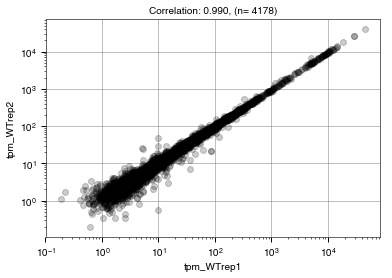

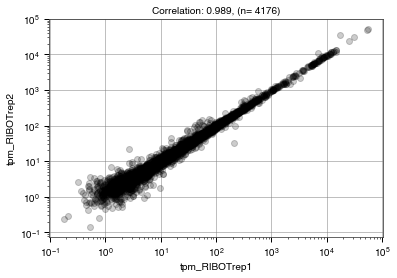

In [9]:
x_label, y_label = ('tpm_WTrep1', 'tpm_WTrep2')
temp_df = df_master[(df_master[x_label].isnull()==False)\
                  & (df_master[y_label].isnull()==False)]
rho, p = stats.spearmanr(temp_df[x_label], temp_df[y_label])
n = len(temp_df.index)
fig, ax = plt.subplots()
ax.loglog(temp_df[x_label], temp_df[y_label], 'ko', alpha=0.2)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.savefig('{}/RNA_WT_comparison.pdf'.format(results_dir), bbox_inches='tight')

#######################################################
#######################################################
#######################################################
x_label, y_label = ('tpm_RIBOTrep1', 'tpm_RIBOTrep2')
temp_df = df_master[(df_master[x_label].isnull()==False)\
                  & (df_master[y_label].isnull()==False)]
rho, p = stats.spearmanr(temp_df[x_label], temp_df[y_label])
n = len(temp_df.index)
fig, ax = plt.subplots()
ax.loglog(temp_df[x_label], temp_df[y_label], 'ko', alpha=0.2)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.savefig('{}/RNA_RIBOT_comparison.pdf'.format(results_dir), bbox_inches='tight')

# Comparing conditions

Denoting significant genes in red which is the only thing that makes this code slightly complicated looking.

It's also important to note that we can define significance based on 2 axes: the qval (~adjusted p-value) and the fold-change. No correct answer here, and you'll get different gene sets with different values of the two parameters below.

In [10]:
###Value to use for significance cutoff
qval = 0.001
logfc_req = 1. ###Note that this is a log2 fold change so a value of 1 equates to a doubling/halving

N = 4154
Corr = 0.9691910763402646 (p=0.0)


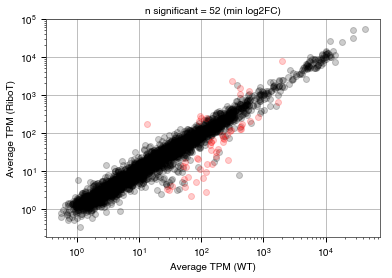

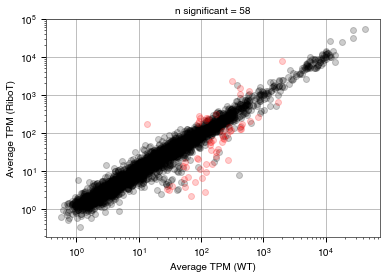

In [11]:
###Significance based on qvalue and logfc defined above
x_label, y_label = ('tpm_avg_WT', 'tpm_avg_RIBOT')
plot_df = df_master[(df_master[x_label].isnull()==False)\
                    & (df_master[y_label].isnull()==False)]

non_sig_df = plot_df[(plot_df['qval'] >= qval) | (plot_df['log2FC'].abs() <= logfc_req)]
sig_df = plot_df[(plot_df['qval'] < qval) & (plot_df['log2FC'].abs() > logfc_req)]
fig, ax = plt.subplots()
ax.loglog(non_sig_df[x_label], non_sig_df[y_label], 'ko', alpha=0.2)
ax.loglog(sig_df[x_label], sig_df[y_label], 'ro', alpha=0.2)
ax.set_title('n significant = {} (min log2FC)'.format(len(sig_df.index)))
ax.set_xlabel('Average TPM (WT)')
ax.set_ylabel('Average TPM (RiboT)')
plt.savefig('{}/RNA_diff_exp_v1.pdf'.format(results_dir), bbox_inches='tight')
print('N = {}'.format(len(non_sig_df.index)+len(sig_df.index)))
rho, p = stats.spearmanr(plot_df[x_label], plot_df[y_label])
print('Corr = {} (p={})'.format(rho, p))
#
#
#
#
###Significance only based on qvalue
non_sig_df = plot_df[(plot_df['qval'] >= qval)]
sig_df = plot_df[(plot_df['qval'] < qval)]
fig, ax = plt.subplots()
ax.loglog(non_sig_df['tpm_avg_WT'], non_sig_df['tpm_avg_RIBOT'], 'ko', alpha=0.2)
ax.loglog(sig_df['tpm_avg_WT'], sig_df['tpm_avg_RIBOT'], 'ro', alpha=0.2)
ax.set_title('n significant = {}'.format(len(sig_df.index)))
ax.set_xlabel('Average TPM (WT)')
ax.set_ylabel('Average TPM (RiboT)')
plt.savefig('{}/RNA_diff_exp_v2.pdf'.format(results_dir), bbox_inches='tight')

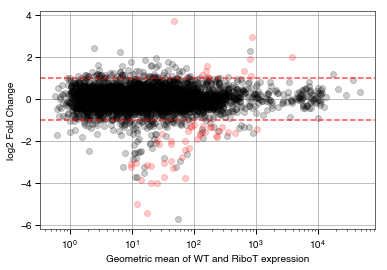

In [12]:
###Slightly different plot
plot_df = df_master
non_sig_df = plot_df[(plot_df['qval'] >= qval) | (plot_df['log2FC'].abs() <= logfc_req)]
sig_df = plot_df[(plot_df['qval'] < qval) & (plot_df['log2FC'].abs() > logfc_req)]

fig, ax = plt.subplots()
ax.semilogx((non_sig_df['tpm_avg_WT']*non_sig_df['tpm_avg_RIBOT'])**(1./2), non_sig_df['log2FC'], 'ko', alpha=0.2)
ax.semilogx((sig_df['tpm_avg_WT']*sig_df['tpm_avg_RIBOT'])**(1./2), sig_df['log2FC'], 'ro', alpha=0.2)
ax.axhline(1, color='r', linestyle='--', alpha=0.7)
ax.axhline(-1, color='r', linestyle='--', alpha=0.7)
ax.set_xlabel('Geometric mean of WT and RiboT expression')
ax.set_ylabel('log2 Fold Change')
plt.savefig('{}/RNA_diff_exp_fc.pdf'.format(results_dir), bbox_inches='tight')

# Write dataframe outputs

In [13]:
df_condensed = df_master[['tpm_avg_WT', 'tpm_avg_RIBOT', 'log2FC', 'qval',\
          'tpm_WTrep1', 'tpm_WTrep2', 'tpm_RIBOTrep1', 'tpm_RIBOTrep2'\
           ]]
df_condensed['fcabs'] = df_condensed['log2FC'].abs()*-1
df_condensed.sort_values(['qval', 'fcabs'], inplace=True)
df_condensed.drop(['fcabs'], axis=1, inplace=True)

/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [14]:
df_master.to_csv('{}/master_table_rna.csv'.format(results_dir))
df_condensed.to_csv('{}/shortened_table_rna.csv'.format(results_dir))
df_super_sig = df_condensed[(df_condensed['qval']<qval) & (df_condensed['log2FC'].abs()>logfc_req)]
df_super_sig.to_csv('{}/shortened_table_rna_most_sig.csv'.format(results_dir))

# Gene families
malE, malK, malP, malF, malG, malQ, malT
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU00038
https://biocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU00039

entB, entH, entC, entE, entA, entF, entS
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU00166

fecA, fecB, fecC, fecD, fecE
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU00151

fepA, fepD, fepC, fepG, fepB
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU0-3963

treC, treB
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU00213

fhuF, fhuA, fhuC
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU00020

yjiY, yjiX
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU0-14208

pyrB, pyrI
https://ecocyc.org/ECOLI/NEW-IMAGE?type=OPERON&object=TU00484

In [15]:
df_super_sig

,tpm_avg_WT,tpm_avg_RIBOT,log2FC,qval,tpm_WTrep1,tpm_WTrep2,tpm_RIBOTrep1,tpm_RIBOTrep2
b4291_fecA,269.727186,19.852819,-3.764085,0.000383,265.505111,273.949261,20.806427,18.899210
b3471_yhhQ,13.521265,176.361611,3.705234,0.000383,13.648672,13.393859,177.626025,175.097197
b3417_malP,53.037241,6.000390,-3.143878,0.000383,53.463743,52.610739,5.961069,6.039711
b1452_yncE,171.821489,31.722700,-2.437323,0.000383,170.448100,173.194879,32.925872,30.519528
b0150_fhuA,189.179346,36.794960,-2.362175,0.000383,187.749556,190.609137,36.485799,37.104121
b3418_malT,144.319553,36.071977,-2.000316,0.000383,143.113431,145.525674,37.036491,35.107464
b3162_deaD,419.568450,1560.526333,1.895055,0.000383,423.720790,415.416110,1612.207597,1508.845070
b4289_fecC,147.801189,14.841288,-3.315970,0.000439,149.777677,145.824702,15.642333,14.040243
b4036_lamB,81.289550,5.063803,-4.004777,0.000442,84.615913,77.963187,5.369988,4.757619
b2095_gatZ,263.260888,88.249904,-1.576827,0.000442,267.196261,259.325515,86.500294,89.999514
